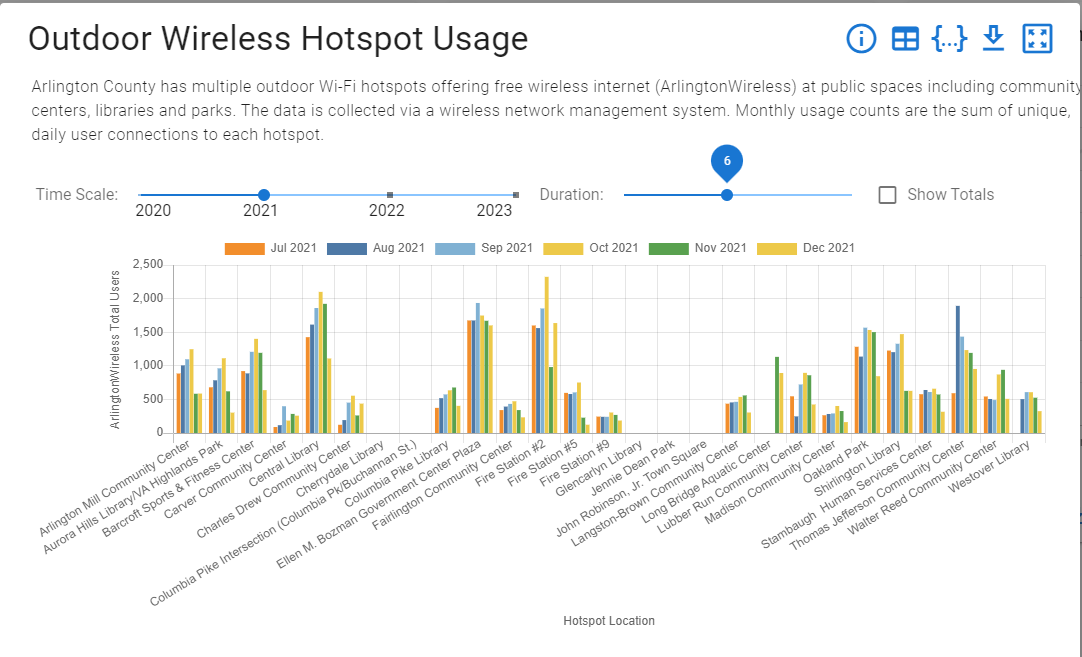

This is a lot of really good data, but this chart could be vastly improved. Comparing the locations objectively is difficult and comparing the usage over time is noisy at best. We can do better.

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Now that all our packages are loaded, let's load our data (from the Excel file) and take a peek at it.

In [152]:
wifi_wide = pd.read_excel('OutdoorWirelessUsageStats.xlsx', header=0, nrows=27)
wifi_wide.head()

,County Hotspot,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,...,2022-09-01 00:00:00,2022-10-01 00:00:00,2022-11-01 00:00:00,2022-12-01 00:00:00,2023-01-01 00:00:00,2023-02-01 00:00:00,2023-03-01 00:00:00,2023-04-01 00:00:00,2023-05-01 00:00:00,2023-06-01 00:00:00
0,Arlington Mill Community Center,2571.0,1863.0,1435.0,1204.0,1223.0,584.0,535,451,605.0,...,1327.0,1170.0,1018.0,929.0,968.0,1385.0,957.0,962,1119,1225
1,Aurora Hills Library/VA Highlands Park,2970.0,3021.0,2674.0,2905.0,2001.0,505.0,581,496,644.0,...,1049.0,1144.0,1075.0,703.0,731.0,754.0,866.0,842,970,948
2,Barcroft Sports & Fitness Center,2641.0,2350.0,1958.0,1837.0,1806.0,626.0,374,590,900.0,...,1176.0,1183.0,1008.0,756.0,843.0,854.0,927.0,1151,1096,1022
3,Carver Community Center,0.0,0.0,129.0,144.0,184.0,43.0,38,37,155.0,...,152.0,205.0,180.0,146.0,135.0,149.0,157.0,192,189,179
4,Central Library,2783.0,2906.0,2860.0,3260.0,3292.0,1134.0,1179,1173,1427.0,...,2651.0,2857.0,2424.0,1957.0,2150.0,2057.0,2261.0,2289,2461,2403


But the problem here is that this data is in "wide" format (where the row/column combinations are what represent a unique entry). But most analysis is done in "long" format (where the ID columns are what identify entries from one another). Here, this has already been "pivoted" from long to wide, so we need to "un-pivot" it. There are many ways of doing this, some more painful than others, but the `melt` funciton will do the trick in one line for us.

In [153]:
wifi = pd.melt(wifi_wide, id_vars=['County Hotspot'])

In [154]:
wifi.head()

,County Hotspot,variable,value
0,Arlington Mill Community Center,2020-07-01,2571.0
1,Aurora Hills Library/VA Highlands Park,2020-07-01,2970.0
2,Barcroft Sports & Fitness Center,2020-07-01,2641.0
3,Carver Community Center,2020-07-01,0.0
4,Central Library,2020-07-01,2783.0


Great! Now each row represents one entry in our dataset and we can process it accordingly. Let's start by checking for null values that can cause problems later. Let's also rename "value" to something more sensible like "user_count", and "variable" to what's actually there: "date".

In [155]:
wifi.isna().sum().sum()

170

In [156]:
wifi.rename({'value':'user_count', 'variable':'date'}, axis=1, inplace=True)
wifi.head()

,County Hotspot,date,user_count
0,Arlington Mill Community Center,2020-07-01,2571.0
1,Aurora Hills Library/VA Highlands Park,2020-07-01,2970.0
2,Barcroft Sports & Fitness Center,2020-07-01,2641.0
3,Carver Community Center,2020-07-01,0.0
4,Central Library,2020-07-01,2783.0


So it looks like we have some null values, but since we know these are probably just from empty Excel cells, we can just delete them since they have no meaning (we can't 'default' them to `0` since that has a different meaning from an empty cell).

In [157]:
wifi.dropna(inplace=True)
wifi.isna().sum().sum()

0

Superb! Now we have to force pandas to have the Date and user counts as a Date object and an int object respectively.

In [158]:
wifi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 971
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   County Hotspot  802 non-null    object        
 1   date            802 non-null    datetime64[ns]
 2   user_count      802 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 25.1+ KB


In [159]:
wifi['date'] = pd.to_datetime(wifi['date'], infer_datetime_format=True)

In [160]:
wifi['user_count'] = wifi['user_count'].astype(int)

ValueError: invalid literal for int() with base 10: 'Site Down'

This error shows us that `"Site Down"` is an entry in our data that is normally numeric. So we have to fix this before we can proceed.

Here though, in "normal" life I'd probably have "cheated" (if it can be called that) and just deleted the `'Site Down'` value by hand in Excel since there's only a few hundred entries and this outlier sticks out like a sore thumb. But this isn't really possible, let alone practical in large data sets with hundreds of thousands of entries. So let's see if we can find a "fancy" way to weed out this wrench in our gears.

In [161]:
wifi[~wifi.user_count.str.isnumeric().isna()]

,County Hotspot,date,user_count
174,Fire Station #5,2021-01-01,Site Down
198,Ellen M. Bozman Government Center Plaza,2021-02-01,Site Down


In [162]:
wifi = wifi.drop(wifi[~wifi.user_count.str.isnumeric().isna()].index)

In [163]:
wifi.user_count = wifi.user_count.astype(int)

<AxesSubplot:>

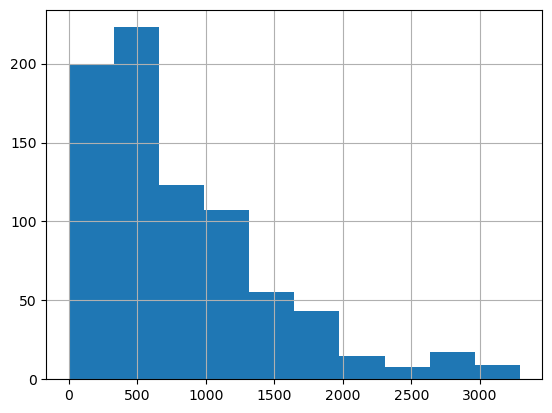

In [164]:
wifi.user_count.hist()

However, histograms are only really truly meaningful when each value is truly independent and isolated from the others in some meaningful way. In all likelihood, the majority of users authenticating into one access point are quite repeat users. The data portal frames these entries as "Monthly usage counts [that] are the sum of unique, daily user connections to each hotspot." So I think "unique, daily user[s]" would mean that if I connect to the same hotspot in the same day, I would be counted as 1. But if I connected to the same hotspot in two different days, I would be counted once each day. With the data we have, the unit of analysis has already been aggregated beyond the level of detail at which we can no longer confirm this (distinct authentication events).

Let's try a couple of other looks at the data.

In [165]:
wifi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 0 to 971
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   County Hotspot  800 non-null    object        
 1   date            800 non-null    datetime64[ns]
 2   user_count      800 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 25.0+ KB


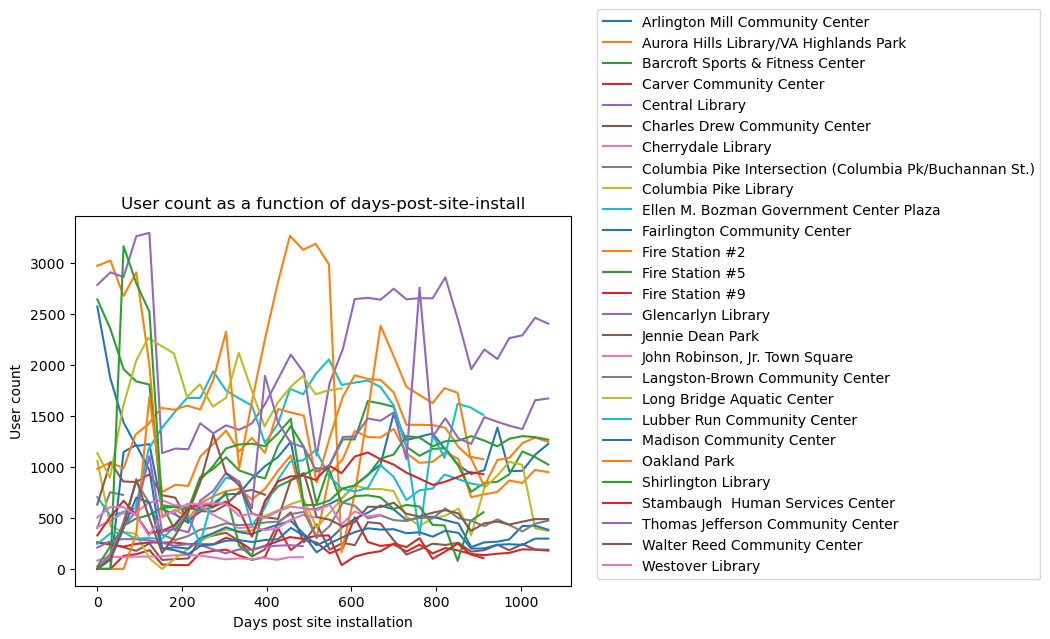

In [188]:
# line-per-site, USERS over time (months after installation)
installation_dates = wifi.groupby("County Hotspot")['date'].min()

wifi['days_post_install'] = wifi.apply(lambda row: \
                             (row['date'] - installation_dates[row["County Hotspot"]]) \
                             .days, axis=1)
spots = wifi.groupby(["County Hotspot"])
fig, ax = plt.subplots()
for label, df in spots:
    ax.plot(df.days_post_install, df.user_count, label=label)

ax.set_title("User count as a function of days-post-site-install")
ax.set_xlabel("Days post site installation")
ax.set_ylabel("User count")
ax.legend(loc='lower center', bbox_to_anchor=(1.5, 0.0))
plt.show()

While this first plot does feel quite messy in some respects (I would never deem something like this as 'ready for public consumption'), you can also clearly see a few patterns. First, there is usually a sharp drop-off in usage at about 150 days or so in several of the sites. Second, you can see there are some spikes and jumps in usage in many places (likely correlated to events or certain personell patterns). But for most sites on most days, typical usage is not terribly dynamic, but more of a plateau.

Even more so, it masks any contrast between the sites from all the noise. Let's take a look at a comparison between the sites and their respective user counts.

<AxesSubplot:xlabel='user_count', ylabel='County Hotspot'>

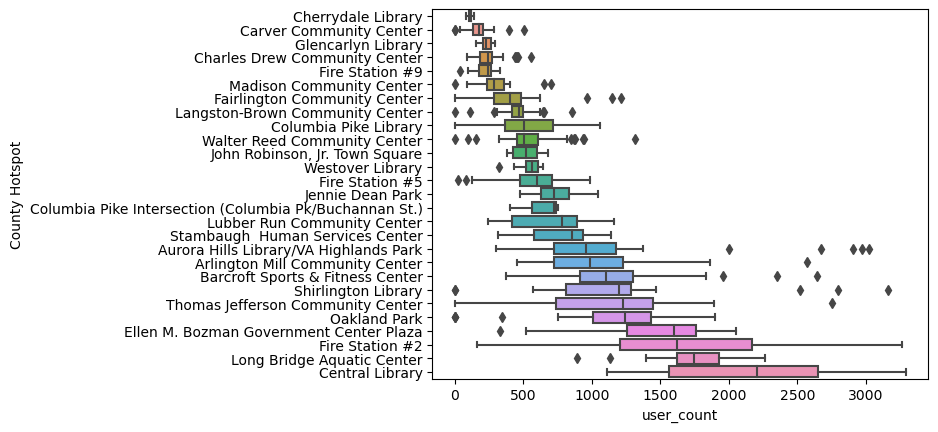

In [189]:
# bar chart, sorted by median, with whiskers
grouped = wifi.loc[:,["County Hotspot", "user_count"]] \
    .groupby(["County Hotspot"]) \
    .median(). \
    sort_values(by="user_count")

sns.boxplot(y="County Hotspot", x="user_count", data=wifi, order=grouped.index)

This shows us SO much more information and in a MUCH more orderly fashion. This is a much better chart and is ready for public consumption or distribution.

It shows us that some sites have quite a high "baseline", it shows us that other sites have a HUGE swing between low and high usage, and that the library and the aquatic center are clearly the most-used sites in the county.